In [0]:
#LSTM Sentiment analysis model for AMZN prices

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive

# This will prompt for authorization.
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [0]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from sklearn import preprocessing
from datetime import datetime, timedelta
import time
from collections import Counter
import os
os.chdir('..')

In [0]:
#getting functions for helper class

In [0]:
def prep_data(ticker,
              stock_file = 'content/drive/My Drive/Colab Notebooks/data/stock/prices-split-adjusted.csv', \
              news_directory = 'content/drive/My Drive/Colab Notebooks/data/news/', \
              econ_file = 'content/drive/My Drive/Colab Notebooks/data/market/economic_indicators.csv', \
              reddit_file = 'content/drive/My Drive/Colab Notebooks/data/market/reddit_sentiments.csv'):
    ''' merge stock closing price data, sec filing data, and newspaper sentiment into one dataframe '''
    
    # load data
    stock_df = pd.read_csv(stock_file, index_col=0)
    stock_df = stock_df[stock_df.symbol==ticker].close
    stock_df.index = pd.to_datetime(stock_df.index)
    news_df = pd.read_csv(news_directory+ticker+'.csv', index_col=0)
    news_df.index = pd.to_datetime(news_df.index)
    econ_df = pd.read_csv(econ_file, index_col=0)
    econ_df.index = pd.to_datetime(econ_df.index)
    reddit_df = pd.read_csv(reddit_file, index_col=0)
    reddit_df.index = pd.to_datetime(reddit_df.index)
    return_df = pd.DataFrame(columns=[stock_df.name]+['stock_'+a for a in list(news_df.columns)]+\
                             list(econ_df.columns)+['market_'+a for a in list(reddit_df.columns)])
    
    # clip price data that doesn't have news coverage or reddit coverage
    d0, d1 = news_df.index[0].date(), news_df.index[1].date()
    startdate = d0-(d1-d0)
    stock_df = stock_df.loc[startdate:]
    
    # iterate through rows, aggregating all data and appending to return_df
    for row_num in range(stock_df.shape[0]):
        new_row = []
        stock_date = stock_df.index[row_num].date()
        new_row += [stock_df.iloc[row_num]]
        new_row += list(news_df.loc[earliest_date_after(stock_date, news_df.index),:])
        new_row += list(econ_df.loc[latest_date_before(stock_date, econ_df.index),:])
        new_row += list(reddit_df.loc[earliest_date_after(stock_date, reddit_df.index),:])
        return_df.loc[stock_date] = new_row
        if row_num % 100 == 0:
            print "%i/%i rows done." % (row_num, stock_df.shape[0]),
    print "\n%s dataframe prepped. %i timepoints, each with %i features." % \
          (ticker, return_df.shape[0], return_df.shape[1])
    return return_df

# practice with AMZN stock data
AMZN_df = prep_data('AMZN')

0/1385 rows done. 100/1385 rows done. 200/1385 rows done. 300/1385 rows done. 400/1385 rows done. 500/1385 rows done. 600/1385 rows done. 700/1385 rows done. 800/1385 rows done. 900/1385 rows done. 1000/1385 rows done. 1100/1385 rows done. 1200/1385 rows done. 1300/1385 rows done. 
AMZN dataframe prepped. 1385 timepoints, each with 14 features.


In [0]:
# display head of X dataframe
AMZN_df.head()

,close,stock_polarity,stock_subjectivity,stock_pos,stock_neg,stock_neu,CCI,BCI,CLI,market_neg,market_neu,market_pos,market_polarity,market_subjectivity
2011-07-01,209.490005,0.010839,0.144678,0.135308,0.018564,0.846128,100.2165,100.1154,99.40932,0.160768,0.184508,0.060792,0.002803,0.225319
2011-07-05,213.190002,0.010839,0.144678,0.135308,0.018564,0.846128,100.2165,100.1154,99.40932,0.160768,0.184508,0.060792,0.002803,0.225319
2011-07-06,214.190002,0.010839,0.144678,0.135308,0.018564,0.846128,100.2165,100.1154,99.40932,0.160768,0.184508,0.060792,0.002803,0.225319
2011-07-07,216.740005,0.010839,0.144678,0.135308,0.018564,0.846128,100.2165,100.1154,99.40932,0.160768,0.184508,0.060792,0.002803,0.225319
2011-07-08,218.279999,0.010839,0.144678,0.135308,0.018564,0.846128,100.2165,100.1154,99.40932,0.148376,0.175877,0.035888,-0.002623,0.260906


In [0]:
def load_stock(df, lookback=25):
    ''' scale data and split into training/test sets '''
    data = df.values
    n_train = list(df.index).index(df.index[-1]+timedelta(-365))
    scaler = preprocessing.StandardScaler() #normalize mean-zero, unit-variance
    scaler.fit(data[:n_train,:])
    data = scaler.transform(data)
    dataX, dataY = [], []
    for timepoint in range(data.shape[0]-lookback):
        dataX.append(data[timepoint:timepoint+lookback,:])
        dataY.append(data[timepoint+lookback,0])
    X_train, X_test = dataX[:n_train], dataX[n_train:]
    y_train, y_test = dataY[:n_train], dataY[n_train:]
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# load practice stock, AMZN
lookback = 25
X_train, y_train, X_test, y_test, scaler = load_stock(df=AMZN_df, lookback=lookback)

1132 training examples, 228 test examples


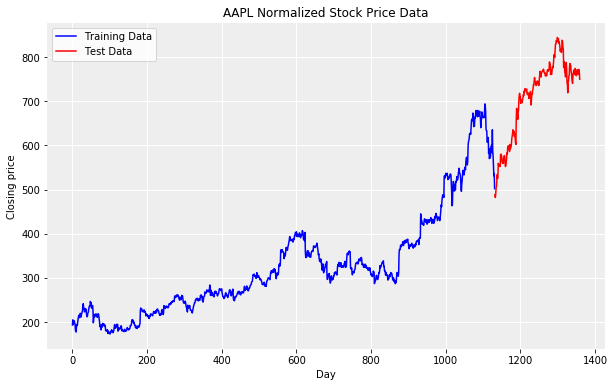

In [0]:
# denormalize training and test price data and plot
print "%i training examples, %i test examples" % (len(y_train), len(y_test))

f,a = simple_ax(figsize=(10,6))
a.plot(range(len(y_train)), inv_price_transform(y_train, scaler), c='b', label='Training Data')
a.plot(range(len(y_train),len(y_test)+len(y_train)), inv_price_transform(y_test, scaler), c='r', label='Test Data')
a.set_title('AMZN Normalized Stock Price Data')
a.set_xlabel('Day')
a.set_ylabel('Closing price')
plt.legend()
plt.show()

In [0]:
#TRAIN LSTM FOR AMZN DATA

model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
#model.add(Dense(32, kernel_initializer="uniform", activation='relu'))        
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

W0726 05:01:51.710731 140541586265984 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 05:01:51.718121 140541586265984 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 05:01:51.728476 140541586265984 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0726 05:01:51.949054 140541586265984 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0726 05:01:51.961894 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25, 128)           73216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 204,929
Trainable params: 204,929
Non-trainable params: 0
_________________________________________________________________


In [0]:
# fit model
t0 = time.time()
history = model.fit(
            X_train,
            y_train,
            batch_size=512,
            epochs=200,
            validation_split=0.05,
            verbose=0)
print "TRAINING DONE. %i seconds to train." % int(time.time()-t0)

W0726 05:02:10.227036 140541586265984 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0726 05:02:11.246881 140541586265984 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



TRAINING DONE. 51 seconds to train.


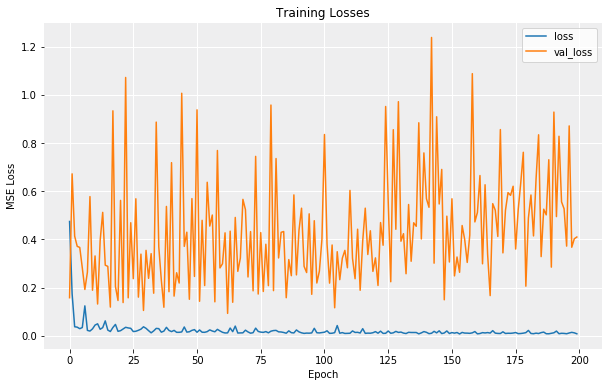

In [0]:
# plot loss and validation loss
f,a = simple_ax(figsize=(10,6))
a.plot(history.history['loss'], label='loss')
a.plot(history.history['val_loss'], label='val_loss')
a.set_title('Training Losses')
a.set_xlabel('Epoch')
a.set_ylabel('MSE Loss')
plt.legend()
plt.show()

In [0]:
##### SAVE MODEL #####
'''
model0 : 12/3/2017 (incomplete data)
model1 : 12/4/2017 (complete dataset)
'''
model.save('content/drive/My Drive/Colab Notebooks/data/model1.h5')

In [0]:
#PREDICT FUTURE PRICES

In [0]:
#### LOAD MODEL #####
model = load_model('content/drive/My Drive/Colab Notebooks/data/model1.h5')

RMSE:  1.538416738587928


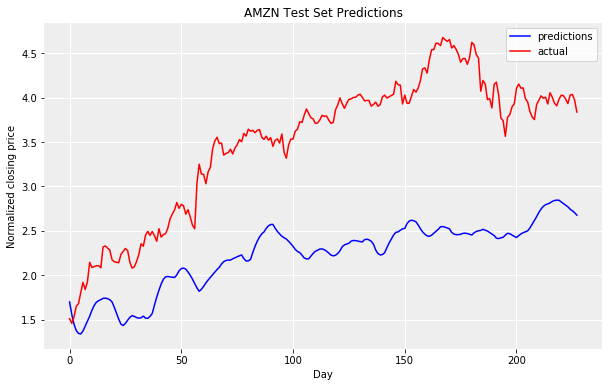

In [0]:
# predict test set
predictions = model.predict(X_test)
print "RMSE: ", np.sqrt(np.mean((predictions-y_test)**2))

f, a = simple_ax(figsize=(10,6))
a.plot(predictions, c='b', label='predictions')
a.plot(y_test, c='r', label='actual')
a.set_ylabel('Normalized closing price')
a.set_xlabel('Day')
a.set_title('AMZN Test Set Predictions')
plt.legend()
plt.show()


In [0]:
def predict_days(startday, days_topredict, data, model):
    ''' starting from startday predict days_topredict stock prices '''
    curr_data = data[startday,:,:]
    predictions = []
    for day in range(days_topredict):
        prediction = model.predict(curr_data.reshape(1,curr_data.shape[0],curr_data.shape[1]))[0][0]
        predictions.append(prediction)
        new_row = curr_data[-1,:]
        new_row[0] = prediction
        curr_data = np.vstack((curr_data[1:,:], new_row))
    return predictions

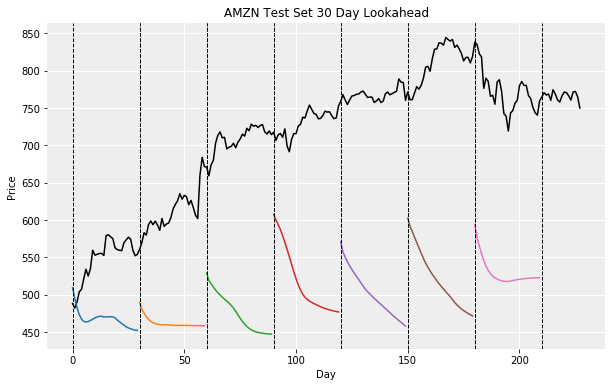

In [0]:
# predict multiple days in future and plot price projection path
days = 30
f, a = simple_ax(figsize=(10,6))
a.plot(inv_price_transform(y_test,scaler), c='k')
for segment in range(int(len(y_test)/days)):
    predictions = predict_days(segment*days, days, X_test, model)
    a.plot(range(segment*days, segment*days+days), inv_price_transform(predictions, scaler))
    a.axvline(segment*days, c='k', linestyle='dashed', linewidth=1)
    a.axvline(segment*days+days, c='k', linestyle='dashed', linewidth=1)
a.set_xlabel('Day')
a.set_ylabel('Price')
a.set_title('AMZN Test Set 30 Day Lookahead')
plt.show()

In [0]:
def decide_buy_sell(startpoint, days_topredict, data, model, return_threshold):
    '''
    predict future prices and return a market decision
    - returns True: "buy long"
    - returns False: "sell short"
    - returns None: "do nothing"
    '''
    predictions = predict_days(startpoint, days_topredict, data, model)
    startprice, maxprice, minprice = predictions[0], max(predictions), min(predictions)
    buyreturn = (maxprice-startprice)/startprice
    sellreturn = (startprice-minprice)/startprice
    if buyreturn>=sellreturn and buyreturn>=return_threshold:
        return True
    elif sellreturn>buyreturn and sellreturn>=return_threshold:
        return False
    return None

def walk_buy_sell(data, model, return_threshold=.05, days_topredict=30):
    ''' walk data making buy/sell decisions '''
    buy_dates, sell_dates = [], []
    for t in range(len(y_test)):
        decision = decide_buy_sell(t, days_topredict, data, model, return_threshold)
        if decision is True:
            buy_dates.append(t)
        elif decision is False:
            sell_dates.append(t)
        if t%20==0:
            print "%i/%i timepoints calculated." % (t+1,len(y_test)),
    print "Data walk complete."
    return buy_dates, sell_dates

buy_dates, sell_dates = walk_buy_sell(X_test, model, return_threshold=0.5, days_topredict=30)


1/228 timepoints calculated. 21/228 timepoints calculated. 41/228 timepoints calculated. 61/228 timepoints calculated. 81/228 timepoints calculated. 101/228 timepoints calculated. 121/228 timepoints calculated. 141/228 timepoints calculated. 161/228 timepoints calculated. 181/228 timepoints calculated. 201/228 timepoints calculated. 221/228 timepoints calculated. Data walk complete.


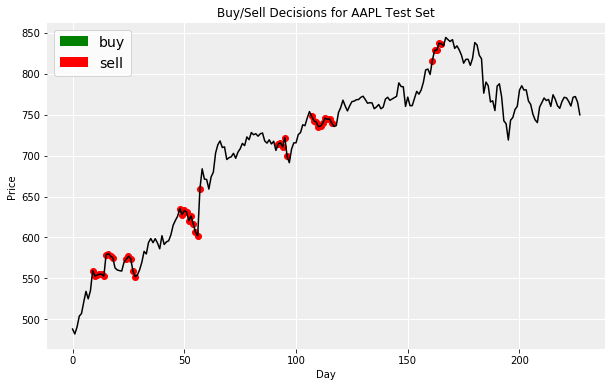

In [0]:
# plot buy/sell timepoint decisions
f,a = simple_ax(figsize=(10,6))
a.plot(inv_price_transform(y_test, scaler), c='k')
a.scatter(buy_dates, inv_price_transform(y_test[buy_dates],scaler), c='g')
a.scatter(sell_dates, inv_price_transform(y_test[sell_dates],scaler), c='r')
a.set_xlabel('Day')
a.set_ylabel('Price')
a.set_title('Buy/Sell Decisions for AMZN Test Set')
recs = [mpatches.Rectangle((0,0),1,1,fc='g'), mpatches.Rectangle((0,0),1,1,fc='r')]
a.legend(recs,['buy', 'sell'], loc=2, prop={'size':14})
plt.show()

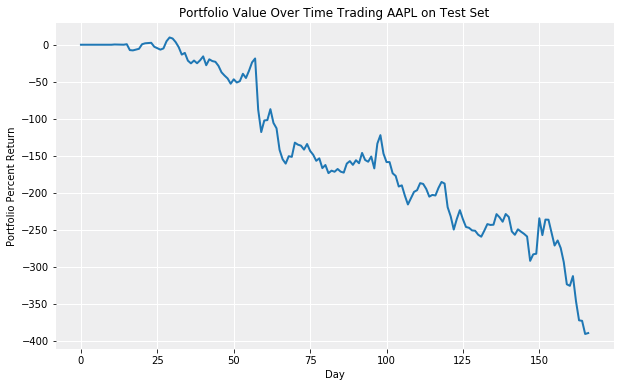

In [0]:
# simulate portfolio value using buy/sell decisions
init_value = 10000
stocks_per_trade = 5
cash = init_value
portfolio = Counter()
returns = [0]
for date in range(max(buy_dates+sell_dates)+1):
    if date in buy_dates: #buy
        portfolio['AMZN'] += stocks_per_trade
        cash = cash - stocks_per_trade*inv_price_transform(y_test[date], scaler)
    elif date in sell_dates: #sell
        portfolio['AMZN'] -= stocks_per_trade
        cash = cash + stocks_per_trade*inv_price_transform(y_test[date], scaler)
    curr_value = cash + portfolio['AMZN']*inv_price_transform(y_test[date],scaler)
    curr_return = 100*(curr_value - init_value)/init_value
    returns.append(curr_return)
    
f,a = simple_ax(figsize=(10,6))
a.plot(returns, linewidth=2)
a.set_xlabel('Day')
a.set_ylabel('Portfolio Percent Return')
a.set_title('Portfolio Value Over Time Trading AMZN on Test Set')
plt.show()


In [0]:
#get data from quandl API used in GAN